### Imports

In [1]:
%pip install seaborn sklearn keras_tuner lightgbm plotly &> /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
# To store data
import warnings

import matplotlib.pyplot as plt

# To do linear algebra
import numpy as np
import pandas as pd
import plotly.graph_objs as go

# To create nicer plots
import seaborn as sns

# To get new datatypes and functions
from cycler import cycler
from keras.layers import Dense, Dropout

# To build models
from keras.models import Sequential
from keras_tuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import RandomSearch

# To gbm light
from lightgbm import LGBMClassifier
from matplotlib.cm import get_cmap

# To create plots
from matplotlib.colors import rgb2hex
from numpy import pi

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
from scipy.optimize import curve_fit

# To process data
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

# To investigate distributions
# from scipy.stats import norm, probplot, skew
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Logging
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)


2023-03-13 02:07:45.561026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 02:07:45.696399: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-13 02:07:46.333333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-13 02:07:46.333406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### Uncompressing data

In [3]:
!./unzip.sh test.csv.zip train.csv.zip

Archive:  test.csv.zip
checkdir:  cannot create extraction directory: test.csv
           File exists
File test.csv.zip unzipped successfully to test.csv
Archive:  train.csv.zip
checkdir:  cannot create extraction directory: train.csv
           File exists
File train.csv.zip unzipped successfully to train.csv


In [4]:
# Load datasets
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Combine boths dataframes
train_data["Data"] = "Train"
test_data["Data"] = "Test"
both_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)
both_data["subject"] = "#" + both_data["subject"].astype(str)

# Create label
label = both_data.pop("Activity")

print("Shape Train:\t{}".format(train_data.shape))
print("Shape Test:\t{}\n".format(test_data.shape))

train_data.head()


Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


### Exploratory Data Analysis

In [5]:
train_data.shape


(7352, 564)

In [6]:
train_data.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


In [7]:
train_data.describe()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


### Checking categorical imbalance

In [8]:
import plotly.express as px

# dummy change
fig = px.pie(train_data, names="Activity", width=700)
fig.update_layout(
    title={
        "text": "Activities distribution in the data",
        "y": 0.95,
        "x": 0.45,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig.show()


In [10]:
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap("viridis")
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1 / (n - 1))]

# Create plot
data = go.Bar(x=label_counts.index, y=label_counts, marker=dict(color=colors))

layout = go.Layout(
    title="Smartphone Activity Label Distribution",
    xaxis=dict(title="Activity"),
    yaxis=dict(title="Count"),
)

fig = go.Figure(data=[data], layout=layout)
iplot(fig)


## Prepare Train And Test Data

In [11]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
x_train, y_train = train_data.iloc[:, :-2], train_data.iloc[:, -1:]
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_train.shape, y_train.shape


((7352, 561), (7352, 1))

In [12]:
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_test.shape, y_test.shape

((2947, 561), (2947, 1))

### One-hot Encoding

In [13]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


In [14]:
x_test.shape, y_test.shape, x_train.shape, y_train.shape


((2947, 561), (2947,), (7352, 561), (7352,))

### Scaling

In [15]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


## Base Model

In [18]:
model = Sequential()
model.add(
    Dense(
        units=64,
        kernel_initializer="normal",
        activation="sigmoid",
        input_dim=x_train.shape[1],
    )
)
model.add(Dropout(0.2))
model.add(Dense(units=6, kernel_initializer="normal", activation="softmax"))
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/10
115/115 [==============================] - 0s 2ms/step - loss: 1.2754 - accuracy: 0.4797 - val_loss: 1.0261 - val_accuracy: 0.6844
Epoch 2/10
115/115 [==============================] - 0s 2ms/step - loss: 0.8851 - accuracy: 0.7141 - val_loss: 0.7495 - val_accuracy: 0.8219
Epoch 3/10
115/115 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.8054 - val_loss: 0.5542 - val_accuracy: 0.8595
Epoch 4/10
115/115 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.8591 - val_loss: 0.4424 - val_accuracy: 0.8653
Epoch 5/10
115/115 [==============================] - 0s 2ms/step - loss: 0.3848 - accuracy: 0.8828 - val_loss: 0.3657 - val_accuracy: 0.8778
Epoch 6/10
115/115 [==============================] - 0s 2ms/step - loss: 0.3219 - accuracy: 0.8974 - val_loss: 0.3053 - val_accuracy: 0.9019
Epoch 7/10
115/115 [==============================] - 0s 2ms/step - loss: 0.2725 - accuracy: 0.9146 - val_loss: 0.2686 - val_accuracy: 0.9158
Epoch 

## Tuning the model

In [19]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int("num_layers", 2, 25)):
        model.add(
            layers.Dense(
                units=hp.Int("units" + str(i), min_value=32, max_value=512, step=32),
                kernel_initializer=hp.Choice("initializer", ["uniform", "normal"]),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"]),
            )
        )
    model.add(
        layers.Dense(
            6,
            kernel_initializer=hp.Choice("initializer", ["uniform", "normal"]),
            activation="softmax",
        )
    )
    model.add(Dropout(0.2))
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=3,
    directory="project",
    project_name="Human_activity_recognition",
)

tuner.search_space_summary()


Search space summary
Default search space size: 27
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 25, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
initializer (Choice)
{'default': 'uniform', 'conditions': [], 'values': ['uniform', 'normal'], 'ordered': False}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units5 (Int)

In [20]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


In [21]:
tuner.results_summary()


Results summary
Results in project/Human_activity_recognition
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 10
units0: 160
initializer: normal
activation: relu
units1: 352
units2: 384
units3: 160
units4: 512
units5: 224
units6: 352
units7: 416
units8: 128
units9: 128
units10: 64
units11: 192
units12: 160
Score: 0.6795611381530762
Trial summary
Hyperparameters:
num_layers: 24
units0: 128
initializer: normal
activation: relu
units1: 448
units2: 128
units3: 416
units4: 480
units5: 160
units6: 32
units7: 384
units8: 448
units9: 224
units10: 96
units11: 480
units12: 384
units13: 32
units14: 32
units15: 32
units16: 32
units17: 32
units18: 32
units19: 32
units20: 32
units21: 32
units22: 32
units23: 32
Score: 0.5578554471333822
Trial summary
Hyperparameters:
num_layers: 6
units0: 320
initializer: uniform
activation: tanh
units1: 352
units2: 32
units3: 32
units4: 32
units5: 32
Score: 0.3504128356774648
Trial summary
Hyperparameters:
num_layers: 13
units0: 192
initializer: un

In [22]:
model = tuner.get_best_models(num_models=1)[0]
history = model.fit(x_train, y_train, epochs=51, validation_data=(x_test, y_test))


Epoch 1/51
230/230 [==============================] - 2s 3ms/step - loss: 2.5596 - accuracy: 0.6383 - val_loss: 0.6533 - val_accuracy: 0.6379
Epoch 2/51
230/230 [==============================] - 1s 3ms/step - loss: 2.2544 - accuracy: 0.6356 - val_loss: 0.6831 - val_accuracy: 0.7950
Epoch 3/51
230/230 [==============================] - 1s 2ms/step - loss: 2.3827 - accuracy: 0.6557 - val_loss: 2.7980 - val_accuracy: 0.6213
Epoch 4/51
230/230 [==============================] - 1s 3ms/step - loss: 3.0395 - accuracy: 0.5578 - val_loss: 0.8792 - val_accuracy: 0.7374
Epoch 5/51
230/230 [==============================] - 1s 3ms/step - loss: 5.1112 - accuracy: 0.4592 - val_loss: 5.1565 - val_accuracy: 0.5161
Epoch 6/51
230/230 [==============================] - 1s 2ms/step - loss: 5.0201 - accuracy: 0.4810 - val_loss: 5.1444 - val_accuracy: 0.5314
Epoch 7/51
230/230 [==============================] - 1s 3ms/step - loss: 5.0343 - accuracy: 0.4860 - val_loss: 5.1368 - val_accuracy: 0.5304
Epoch 

In [23]:
model.summary()

import tensorflow as tf
from tensorflow import keras

Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fitt = model.fit(x_train,y_train, epochs=200, validation_data=(x_test,y_test), callbacks=Callback)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               89920     
                                                                 
 dense_1 (Dense)             (None, 352)               56672     
                                                                 
 dense_2 (Dense)             (None, 384)               135552    
                                                                 
 dense_3 (Dense)             (None, 160)               61600     
                                                                 
 dense_4 (Dense)             (None, 512)               82432     
                                                                 
 dense_5 (Dense)             (None, 224)               114912    
                                                                 
 dense_6 (Dense)             (None, 352)               7

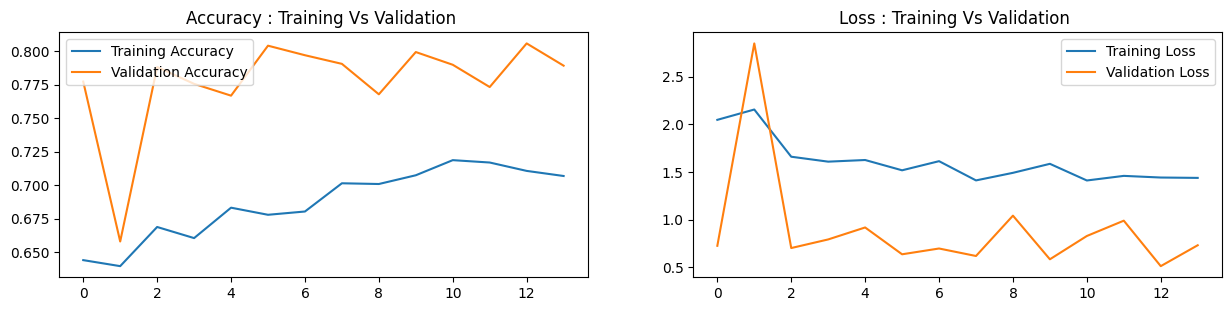

In [26]:
accuracy = mo_fitt.history["accuracy"]
loss = mo_fitt.history["loss"]
validation_loss = mo_fitt.history["val_loss"]
validation_accuracy = mo_fitt.history["val_accuracy"]

# dynamically set x based on y
x = range(len(validation_loss))

plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(x, accuracy, label="Training Accuracy")
plt.plot(x, validation_accuracy, label="Validation Accuracy")
plt.legend(loc="upper left")
plt.title("Accuracy : Training Vs Validation ")

plt.subplot(2, 2, 2)
plt.plot(x, loss, label="Training Loss")
plt.plot(x, validation_loss, label="Validation Loss")
plt.title("Loss : Training Vs Validation ")
plt.legend(loc="upper right")
plt.show()
